# Data Preprocessing

In [26]:
##--[1]impotamos las librerias openCV y OS
import cv2,os
#importamos en la libreria numpy
import numpy as np

In [27]:
###--guardamos en una variable la ubicación de la carpeta con las fotos
data_path=r'D:\KONECTA\APLICACIONES\MASK_DETECTOR\dataset'

###--leemos los dos nombres de las carpteas que servirán para categorizar las fotos (with mask, without mask)
categories=os.listdir(data_path)

###--obtenemos el valor 0 y 1 de acuerdo a la cantidad de categorias.
labels=[i for i in range(len(categories))]

###--le asignamos los valores a la categoria(with mask=0, without mask=1)
label_dict=dict(zip(categories,labels)) 

###--validamos los valores
print(data_path)
print(categories)
print(labels)
print(label_dict)

D:\KONECTA\APLICACIONES\MASK_DETECTOR\dataset
['with mask', 'without mask']
[0, 1]
{'with mask': 0, 'without mask': 1}


In [28]:
###--En una variable definirmos el valor del tamaño de la imagen y creamos dos listas vacías.
img_size=100
data=[]
target=[]

###--creamos una función FOR anidada,que levante las imagenes,
for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
    
    ###-Ppor cada imagen guardada en img_names hace la lectura de imagen con openCV y las guarda en img
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:#convierte las imagenes en escalas de grises
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
            #reduce las imagenes en grises a un tamaño de 50*50,necesitamos un tamaño común fijo para todas las imágenes en el conjunto de datos
            resized=cv2.resize(gray,(img_size,img_size))
            #guardamos los resultados en data que fue creado al inicio de este codigo
            data.append(resized)
            #guardamos la etiqueta (categorizada)
            target.append(label_dict[category])
           
        ##si se produce alguna excepción, la excepción se imprimirá aquí. Y pasar a la siguiente imagen
        except Exception as e:
            print('Exception:',e)

In [29]:
#hacemos una conversión de datos al tipo array, transformando los datos con una diivisión de 255.0.
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))

#Conviertimos  vector de clase (target) a una matriz de clase binaria.
target=np.array(target)
from keras.utils import np_utils
new_target=np_utils.to_categorical(target)

#validamos
print(data.shape)
print(target.shape)

(1376, 100, 100, 1)
(1376,)


In [30]:
#guardamos los datos de las imágenes preparadas y el targen dentro de nuestra carpeta de proyecto.
np.save(r'D:\KONECTA\APLICACIONES\MASK_DETECTOR\data',data)
np.save(r'D:\KONECTA\APLICACIONES\MASK_DETECTOR\target',new_target)

# Convolutional Neural Network Architecture

In [31]:
#cargamos los datos de las imagenes que preparamos en la etapa anterior
data=(r'D:\KONECTA\APLICACIONES\MASK_DETECTOR\data.npy')
target=(r'D:\KONECTA\APLICACIONES\MASK_DETECTOR\target.npy')

data=np.load(data)
target=np.load(target)

In [32]:
##importamos las librerias el entrenamiento del modelo.
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

# La primera capa CNN seguida de las capas Relu y MaxPooling
model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#La segunda capa de convolución seguida de las capas Relu y MaxPooling
model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Capa plana para apilar las convoluciones de salida de la segunda capa de convolución
model.add(Flatten())
model.add(Dropout(0.5))

# Capa densa de 64 neuronas
model.add(Dense(50,activation='relu'))

# La capa final con dos salidas para dos categorías
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [33]:
#creamos las muestras de test y train
from sklearn.model_selection import train_test_split
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [34]:
## Ejecución del modelo,con 20 interacciones, se ejecuta cada modelo y muestra sus resultados de precisión.
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Train on 990 samples, validate on 248 samples
Epoch 1/20
990/990 [==============================] - 36s 36ms/step - loss: 0.6802 - accuracy: 0.5707 - val_loss: 0.7403 - val_accuracy: 0.5000
Epoch 2/20
990/990 [==============================] - 36s 36ms/step - loss: 0.5658 - accuracy: 0.7162 - val_loss: 0.4323 - val_accuracy: 0.8306
Epoch 3/20
990/990 [==============================] - 36s 36ms/step - loss: 0.3630 - accuracy: 0.8495 - val_loss: 0.3000 - val_accuracy: 0.9153
Epoch 4/20
990/990 [==============================] - 36s 36ms/step - loss: 0.2427 - accuracy: 0.9091 - val_loss: 0.2770 - val_accuracy: 0.8790
Epoch 5/20
990/990 [==============================] - 36s 36ms/step - loss: 0.2043 - accuracy: 0.9242 - val_loss: 0.2310 - val_accuracy: 0.9194
Epoch 6/20
990/990 [==============================] - 36s 36ms/step - loss: 0.1292 - accuracy: 0.9535 - val_loss: 0.2007 - val_accuracy: 0.9355
Epoch 7/20
990/990 [==============================] - 36s 36ms/step - loss: 0.0886 - accur

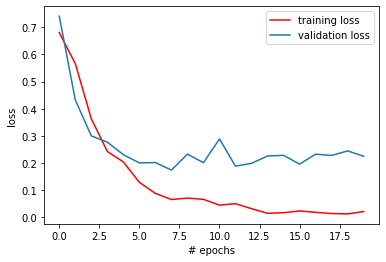

In [35]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

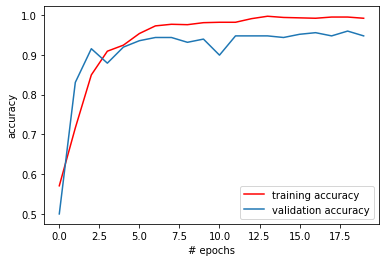

In [37]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [44]:
print(model.evaluate(test_data,test_target))

138/138 [==============================] - 1s 9ms/step
[0.25199298927749414, 0.9057971239089966]


# Detecting Faces with and without masks

In [15]:
##--importamos las librerias necesarias
from keras.models import load_model
import cv2
import numpy as np
from pygame import mixer

In [23]:
##--cargamos el modelo, debe estar guardado en tu directoriode anaconda.
model = load_model('model-016.model')
##--cargamos face_cascade que un algortimo preentrenado para identificación de rostro frontal con OPENCV
face_cascade = 'C:\\Users\\LENOVO\\haarcascade_frontalface_default.xml'
##--definimos la clasificación de face_cascade
face_clsfr=cv2.CascadeClassifier(face_cascade)
##--definimos la captura de video
source=cv2.VideoCapture(0)
##--definimos las respuestas
labels_dict={0:'MASK',1:'NO MASK'}
##--definimos el color de escalas de grises.
color_dict={0:(0,255,0),1:(0,0,255)}

In [24]:

while(True):
    ##--capturamos las imagenes de la camara
    ret,img=source.read()
    ##--lo llevamos a la escala de grises
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ##--usamos la identificacion de la casilla del rostro
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
        face_img=gray[y:y+w,x:x+w]
        ##--reducimos el tamaño de la imagen
        resized=cv2.resize(face_img,(100,100))
        ##--normalizamos los datos con un división
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        ##--hacemos la predicción con el modelo ya entrenado
        result=model.predict(reshaped)
        ##--obtenemos del array la clasificación
        label=np.argmax(result,axis=1)[0]
        
        ##--función para renombrar la clasificación, si es 1 entonces no cumple, si es 0 entonces cumple
        if(label == 'with_mask'):
            print('cumple')
        else:
            print("no cumple")
        
        ##--definimos el ractangulo y le imprimimos el colo de acuerdo a la respuesta definida lineas arriba
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple


no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple


no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple


no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple


no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
no cumple
